# What proportion of Wikipedia ant articles are about specific species of ants?

In [11]:
import requests
import time
import pandas as pd

In [12]:
url = "https://en.wikipedia.org/w/api.php" # This is the only endpoint you will need!

In [13]:
# choose the parameters that you need for your question
params = {
    "action": "query",
    "list": "random",
    "rnnamespace": 0,  # 0 = main namespace (articles only)
    "rnlimit": 1,
    "format": "json"
}

# create a header that describes this is for educational purposes
headers = {
    'User-Agent': 'StatisticsEducationBot/1.0 (Statistics Class Project; educational use)'
}

In [14]:
# Fetch data
session = requests.Session()
response = session.get(url=url, params=params, headers=headers)

print("Status code:", response.status_code)
data = response.json()
data

Status code: 200


{'batchcomplete': '',
 'continue': {'rncontinue': '0.893342092816|0.893342613364|29333417|0',
  'continue': '-||'},
 'query': {'random': [{'id': 51984367,
    'ns': 0,
    'title': 'Kari Nissen Brodtkorb'}]}}

In [15]:
# Here's how you can grab just the title
article_title = data['query']['random'][0]['title']
print(f"Article: {article_title}\n")


Article: Kari Nissen Brodtkorb



In [16]:
# Here's how you grab the page's content. Notice that we are using different parameters! This means we need to make a new request.
content_params = {
    "action": "query",
    "titles": article_title,
    "prop": "extracts",  # This gets the text content
    "explaintext": True,  # Plain text instead of HTML
    "format": "json"
}

response = session.get(url=url, params=content_params, headers=headers)
data = response.json()

pages = data['query']['pages']
page_id = list(pages.keys())[0]
content = pages[page_id].get('extract', 'No content available')

print("Page content:")
print(content)

Page content:
Kari Irene Nissen Brodtkorb (born 1942) is a Norwegian architect and educator. Recognized as one of Norway's leading housing designers, in 1994 she was awarded the cherished Houen Foundation Award for her Stranden complex located on Oslo's Aker Brygge. Brodtkorb taught at the Oslo School of Architecture and Design in the early 1990s.


== Biography ==
Born on 3 March 1942 in Oslo, Brodtkorb was the daughter of the business administrator Roald Nissen and Ragnhild Marie Heiding, a secretary. On graduating from the Norwegian Institute of Technology in 1965, she worked as an architect for Harald Hille's firm (1966–71) and for Anker & Hølaas (1977–85) where she became a partner. From 1985, she ran her own firm in Bærum.
She adopted an innovative approach to residential architecture, combining high engineering standards with distinctively attractive designs. Her developments in Oslo, in a white European modernism style, include 30 townhouses on Gullkroken, 110 apartments on Hof

In [17]:
import random
import pandas as pd

# Keywords to classify articles as ant-related
ANT_KEYWORDS = ["Formicidae", "Formica"]

def is_ant_related(title, extract):
    """
    Checks if an article is about ants by searching for keywords.
    """
    text = (title + " " + extract).lower()
    for kw in ANT_KEYWORDS:
        if kw.lower() in text:
            return True
    return False

def get_10_ant_articles(session, url, headers):
    """
    Pulls 10 random articles from Category:Ants
    Returns a list of dicts: [{'title': ..., 'extract': ..., 'ant_related': True/False}, ...]
    """
    # Step 1: get pages from Category:Ants
    params = {
        "action": "query",
        "list": "categorymembers",
        "cmtitle": "Category:Ants",
        "cmlimit": 500,
        "format": "json"
    }
    response = session.get(url=url, params=params, headers=headers)
    data = response.json()
    members = data["query"]["categorymembers"]

    # Filter to article pages only
    article_pages = [m for m in members if m["ns"] == 0]

    if len(article_pages) < 10:
        raise ValueError("Not enough ant articles in Category:Ants")

    # Step 2: randomly select 10 articles
    selected_pages = random.sample(article_pages, 10)
    articles = []

    # Step 3: fetch content and classify
    for page in selected_pages:
        title = page["title"]
        content_params = {
            "action": "query",
            "titles": title,
            "prop": "extracts",
            "explaintext": True,
            "format": "json"
        }
        content_response = session.get(url=url, params=content_params, headers=headers)
        page_data = list(content_response.json()["query"]["pages"].values())[0]
        extract = page_data.get("extract", "")

        ant_related = is_ant_related(title, extract)
        articles.append({
            "title": title,
            "extract": extract,
            "ant_related": ant_related
        })

    return articles

# -----------------------------
# Run 10 trials and calculate proportions
# -----------------------------
trials = []
n_trials = 100

for t in range(n_trials):
    articles = get_10_ant_articles(session, url, headers)
    n_ant = sum(a["ant_related"] for a in articles)
    n_not_ant = 10 - n_ant
    prop_ant = n_ant / 10
    prop_not_ant = n_not_ant / 10
    trials.append({
        "trial": t+1,
        "ant_related": prop_ant,
        "not_ant_related": prop_not_ant
    })

# Convert to DataFrame for analysis
df = pd.DataFrame(trials)
print(df)


    trial  ant_related  not_ant_related
0       1          0.4              0.6
1       2          0.4              0.6
2       3          0.3              0.7
3       4          0.4              0.6
4       5          0.4              0.6
..    ...          ...              ...
95     96          0.5              0.5
96     97          0.3              0.7
97     98          0.6              0.4
98     99          0.4              0.6
99    100          0.5              0.5

[100 rows x 3 columns]


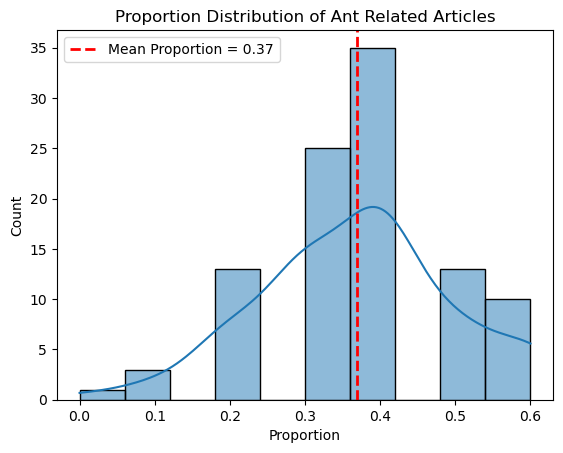

In [20]:
import seaborn as sns
import matplotlib.pyplot as plt

# Choose the column you want to plot
col = "ant_related"   # or "not_ant_related"

sns.histplot(df[col], bins=10, kde=True)

# Compute the mean of that column
mean_val = df[col].mean()

plt.axvline(mean_val, color='red', linestyle='--', linewidth=2,
            label=f"Mean Proportion = {mean_val:.2f}")

plt.legend()
plt.xlabel("Proportion")
plt.title(f"Proportion Distribution of Ant Related Articles")
plt.show()


In [31]:
dfp = pd.DataFrame(df["ant_related"])
stdev = dfp["ant_related"].std()
mean = dfp["ant_related"].mean()
import math
SE = stdev/(math.sqrt(len(dfp)))
z_score = 1.96
ME = z_score*SE
CI_upper = mean + ME
CI_lower = mean - ME
print("Mean: ", mean)
print("Standard Deviation: ", stdev)
print("Standard Error: ", SE)
print("Margin of Error: ", ME)
print("95% Confidence Interval:")
print("Upper: ", CI_upper)
print("Lower: ", CI_lower)

Mean:  0.36899999999999994
Standard Deviation:  0.12846805207537165
Standard Error:  0.012846805207537166
Margin of Error:  0.025179738206772845
95% Confidence Interval:
Upper:  0.39417973820677277
Lower:  0.3438202617932271


# Answer:

The probability distribution of the number of ant articles that are about specific types of ants is approximately normal, with a few gaps in the histogram. The mean of the probability distribution is .369, meaning that the average proportion of ant articles that are actually about ants is .369, with a standard deviation of .1284. The 95% confidence interval is (Upper = .3438, Lower = .3941), with a Standard Error of .01284 and a Margin of Error of 0.02517.